# BatchIterator

In [1]:
# !pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main

In [2]:
import os
if os.name =='nt':
    os.add_dll_directory(r"C:\Program Files\openslide\bin") # windows
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
from dicfg.magics import ConfigMagics
from wholeslidedata.samplers.callbacks import BatchCallback

from batchgenerators.transforms.abstract_transforms import AbstractTransform, Compose
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, \
    ContrastAugmentationTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform, MirrorTransform
from batchgenerators.transforms.utility_transforms import RemoveLabelTransform, RenameTransform, NumpyToTensor

# This will allow loading yaml in an notebook cell
ConfigMagics.register_magics()

import matplotlib.pyplot as plt

import numpy as np

from multiprocessing import freeze_support

In [3]:
from wholeslidedata.iterators.batchiterator import BatchIterator

class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
    def __next__(self):
        x_batch, y_batch, _ = super().__next__()
        x_batch = x_batch.transpose(0,3,1,2).astype('float32')/255
        y_batch = y_batch.astype('int16')
        return {'data': x_batch, 'seg': y_batch}

In [4]:
class nnUnetBatchCallback(BatchCallback):
    
    # patch_size_spatial (width/height)
    def __init__(self, patch_size_spatial):
        tr_transforms = []
        rotation_for_DA= {'x': (-3.141592653589793, 3.141592653589793), 'y': (0, 0), 'z': (0, 0)}
        tr_transforms.append(SpatialTransform(
            patch_size_spatial, 
            patch_center_dist_from_border=None,
            do_elastic_deform=False,
            alpha=(0, 0),
            sigma=(0, 0),
            do_rotation=True,
            angle_x=rotation_for_DA['x'],
            angle_y=rotation_for_DA['y'],
            angle_z=rotation_for_DA['z'],
            p_rot_per_axis=1,  # todo experiment with this
            do_scale=True,
            scale=(0.7, 1.4),
            border_mode_data="constant",
            border_cval_data=0,
            order_data=3,
            border_mode_seg="constant",
            border_cval_seg=-1,
            order_seg=1,
            random_crop=False,  # random cropping is part of our dataloaders
            p_el_per_sample=0,
            p_scale_per_sample=0.2,
            p_rot_per_sample=0.2,
            independent_scale_for_each_axis=False  # todo experiment with this
        ))

        tr_transforms.append(GaussianNoiseTransform(p_per_sample=0.1))
        tr_transforms.append(GaussianBlurTransform((0.5, 1.), different_sigma_per_channel=True, p_per_sample=0.2,
                                                   p_per_channel=0.5))
        
        # tr_transforms.append(BrightnessMultiplicativeTransform(multiplier_range=(0.75, 1.25), p_per_sample=0.15))
        
        
        tr_transforms.append(ContrastAugmentationTransform(p_per_sample=0.15))
        tr_transforms.append(SimulateLowResolutionTransform(zoom_range=(0.5, 1), per_channel=True,
                                                            p_per_channel=0.5,
                                                            order_downsample=0, order_upsample=3, p_per_sample=0.25,
                                                            ignore_axes=None))
        tr_transforms.append(GammaTransform((0.7, 1.5), True, True, retain_stats=True, p_per_sample=0.1))
        tr_transforms.append(GammaTransform((0.7, 1.5), False, True, retain_stats=True, p_per_sample=0.3))
        

        
        tr_transforms.append(MirrorTransform((0,1)))
        tr_transforms.append(RemoveLabelTransform(-1, 0))
        tr_transforms.append(RenameTransform('seg', 'target', True))
        
        
        self._transforms = Compose(tr_transforms)
    
    def __call__(self, x_batch, y_batch):
        # x_batch = [x/255 for x in x_batch]
        # print(type(x_batch), type(y_batch))
        # print(len(x_batch), len(y_batch))
        # print(x_batch[0].shape, y_batch[0].shape)
        x_batch = np.stack([x for x in x_batch]).transpose((0, 3, 1, 2)).astype('float32')
        y_batch = np.expand_dims(np.stack(y_batch).astype('int16'), 1)
        # print(x_batch.shape, y_batch.shape)
        batch = self._transforms(**{'data': x_batch, 'seg': y_batch})
        # print('transformed')
        # print(data)
        x_batch, y_batch = batch['data'], batch['target']
        return x_batch.transpose((0, 2, 3, 1)), y_batch.squeeze()

In [5]:
# %%yaml user_config 

# wholeslidedata:
#     default:
#         yaml_source:
#             training:
#             -   wsi: 
#                     path: C:\Users\joeyspronck\Documents\Other\wsirois\wsi-level-annotations\images\100B.tif
#                 wsa: 
#                     path: C:\Users\joeyspronck\Documents\Other\wsirois\wsi-level-annotations\annotations-tissue-cells-xmls\100B.xml
                        
#         labels:
#             invasive tumor: 1
#             tumor-associated stroma: 2
#             in-situ tumor: 3
#             healthy glands: 4
#             necrosis not in-situ: 5
#             inflamed stroma: 6
#             rest: 7
            
#         batch_shape:
#             batch_size: 2
#             spacing: 1.0
#             shape: [512, 512, 3]
            
#         batch_callbacks: 
#             - "*object": __main__.NNUnetBatchCallback
#               patch_size_spatial: [512,512]

In [6]:
%%yaml user_config 

wholeslidedata:
    default:
        backend: 
            'asap'
        
        yaml_source:
            training:
            -   wsi: 
                    path: /data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/100B.tif
                wsa: 
                    path: /data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml
                        
        labels:
            invasive tumor: 1
            tumor-associated stroma: 2
            in-situ tumor: 3
            healthy glands: 4
            necrosis not in-situ: 5
            inflamed stroma: 6
            rest: 7
            
        batch_shape:
            batch_size: 2
            spacing: 1.0
            shape: [512, 512, 3]
            
        batch_callbacks: 
            - "*object": __main__.nnUnetBatchCallback
              patch_size_spatial: [512,512]

:::{seealso}
 - For more information about the **mode**, please see the user guide about [modes](./modes)
 - For an explanation about the **user_config** please see the [batchiterator configuration](/userguide/index.html#batchiterator-configuration)
:::

In [7]:
%matplotlib inline

In [8]:
# x_batch.shape #(2, 512, 512, 3)

In [9]:
# y_batch.shape #(2, 512, 512)

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


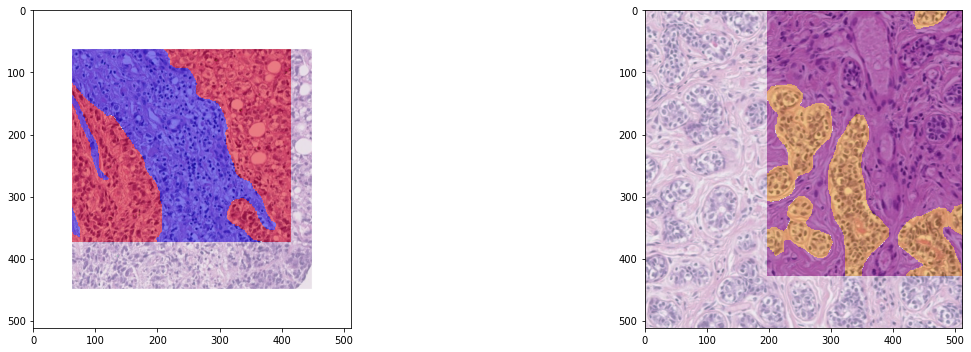

1


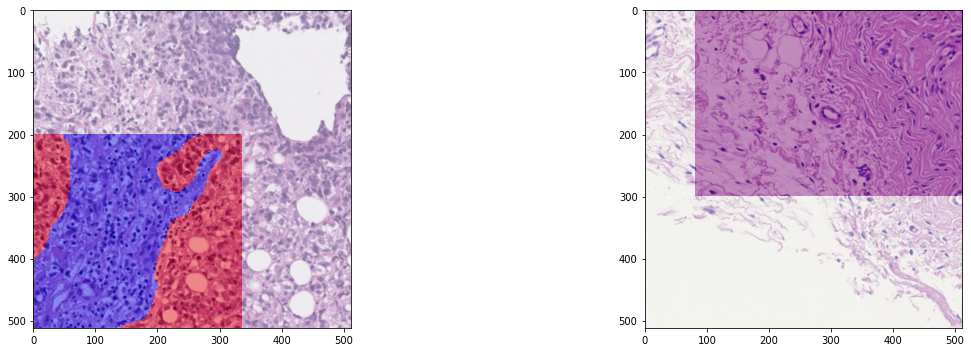

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


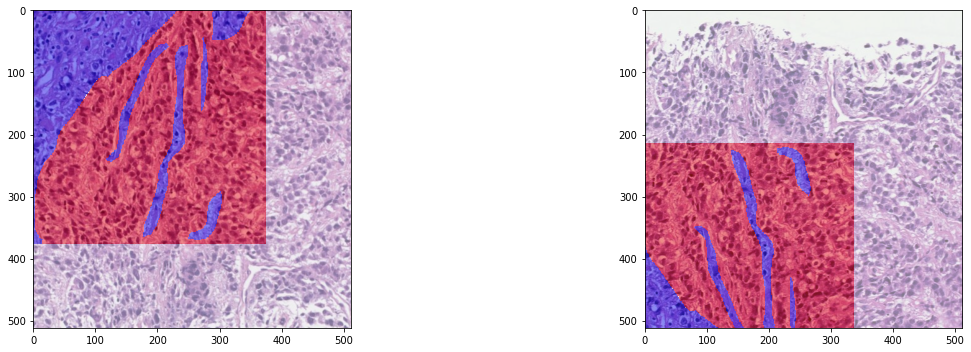

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


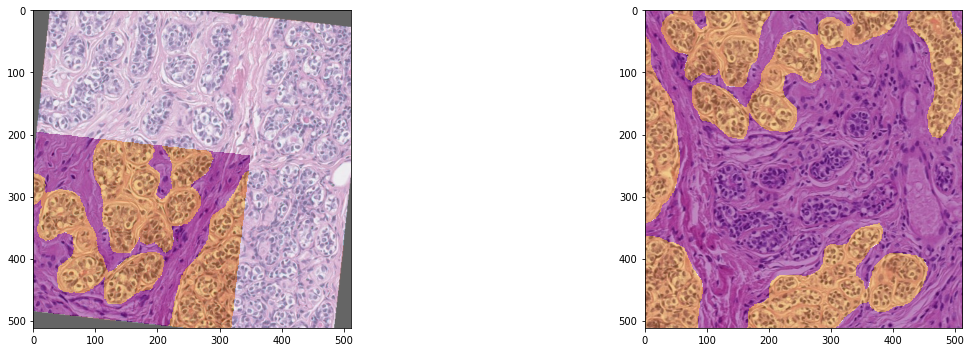

In [10]:
with create_batch_iterator(user_config=user_config, 
                           context='spawn' if os.name=='nt' else 'fork',
                           mode='training',
                           # iterator_class=WholeSlidePlainnnUnetBatchIterator
                          ) as training_batch_generator:
    for i in range(4):
        print(i)
        batch =  next(training_batch_generator)
        # break
        plot_batch(batch[0], batch[1])

In [11]:
len(batch)

3

In [12]:
plt.imshow(batch['data'][0].transpose(1, 2, 0))

TypeError: list indices must be integers or slices, not str

In [ ]:
batch

In [ ]:
batch['data'][0]

In [ ]:
x_ex = [np.ones((512, 512, 3)), np.ones((512, 512, 3))]

In [ ]:
np.stack([x for x in x_ex]).transpose((0, 3, 1, 2)).shape

In [ ]:
np.concatenate(x_ex, axis=0).shape

In [ ]:
batch['data'].shape

In [ ]:
batch['target'].shape

In [ ]:
batch

In [ ]:
batch['data'].shape

In [ ]:
batch['seg'].shape

In [ ]:
x_batch.shape

In [ ]:
y_batch.shape